In [0]:
import sys
sys.version

%reset -f
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'
import sys
sys.version

!pip3 install 'torch==0.4.0'
!pip3 install 'torchvision==0.2.1'
!pip3 install --no-cache-dir -I 'pillow==5.1.0'
#!pip3 install torchvision
!pip install 'livelossplot==0.2.2'
!pip install 'imageio==2.4.1'
!pip install  'torchnet==0.0.4'
!pip install 'torchvision==0.2.1'

print('done')
# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
import os
os._exit(0)

    100% |████████████████████████████████| 484.0MB 27kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5ca88000 @  0x7ffb4caa72a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 5.4MB/s 
    100% |████████████████████████████████| 2.0MB 13.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
    100% |████████████████████████████████| 2.0MB 39.5MB/s 
    100% |████████████████████████████████| 256kB 24.7MB/s 
    100% |████████████████████████████████| 204kB 26.6MB/s 
  Running setup.py bdist_wheel for torchnet ... - \ done
  Stored in directory: /root/.cache/pip/wheels/e1/03/fb/1c212c2f20905cdf97fe39022946cf16b8e66ed754a6663400
  Running setu

In [0]:
#!pip3 install 'torchvision==0.2.1'
# !pip install 'torchvision==0.2.1'

In [1]:
from torch.utils.data import Dataset
from skimage import io, transform
from torch.utils.data import Dataset
import os
import pandas as pd
from PIL import Image
import random 
import numpy as np
from torchvision import transforms, datasets
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np 
# from scipy.misc import imread 
from imageio import imread
import torch
from livelossplot import PlotLosses
from torch.utils.data import Dataset, DataLoader
import torchnet

Using TensorFlow backend.


In [2]:
print('__pyTorch VERSION:', torch.__version__)
use_cuda = torch.cuda.is_available()
print('use_cuda = {0}'.format(use_cuda))

DATA_FOLDER ='data'

SEED = 999

def fixSeed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if use_cuda:
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

fixSeed(SEED)

__pyTorch VERSION: 0.4.0
use_cuda = True


In [4]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle/


Saving kaggle.json to kaggle.json
kaggle.json


In [5]:
!kaggle datasets download -d vbookshelf/v2-plant-seedlings-dataset
!unzip -q v2-plant-seedlings-dataset.zip -d data
!ls data

100% 1.59G/1.59G [00:27<00:00, 84.7MB/s]
100% 1.59G/1.59G [00:27<00:00, 62.2MB/s]
 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [6]:
!ls data

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherd’s Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [0]:
image_size = 224

In [0]:
class DatasetLoader(Dataset):

    def __init__(self, df, transform):
        self._df = df
        self._transform = transform


    @staticmethod
    def find_classes(root_dir):

        labels_folders = os.listdir(root_dir)
        index_class = {}
        xs = []
        ys = []
        class_names = []
        for index, label in enumerate(labels_folders):
            index_class[index] = label
            class_names.append(label)
            y_train_folder = os.path.join(root_dir, label)
            for file in os.listdir(y_train_folder):
                train_example_path = os.path.join(y_train_folder, file)
                xs.append([train_example_path, label, index])
                ys.append(index)

        df = pd.DataFrame(xs, columns=['file', 'category', 'category_id'])

        return  index_class, df,class_names


    def __len__(self):
        return len(self._df)

    def __getitem__(self, idx):
        current_element = self._df.iloc[idx]
        fullname = current_element['file']

        image = Image.open(fullname).convert('RGB')

        if self._transform:
            image = self._transform(image)

        label = current_element['category_id']

        return image, label

In [8]:
from sklearn.model_selection import train_test_split

index_class, data_df, class_names = DatasetLoader.find_classes(DATA_FOLDER)

all_data, test_data = train_test_split(data_df, test_size=0.1, random_state=0, stratify=data_df[['category']])

train_data, valid_data = train_test_split(all_data, test_size=0.2, random_state=0, stratify=all_data[['category']])



# all_data = data_df.iloc[all_data_indexes]

# all_data = data_df.sample(frac=0.90)
# test_data = data_df[~data_df['file'].isin(all_data['file'])]
# train_data = all_data.sample(frac=0.80)
# valid_data = all_data[~all_data['file'].isin(train_data['file'])]
print('total : {0}  trainning size  {1} validation size {2} test size {3}'.format( len(data_df), len(train_data),len(valid_data),len(test_data)))

total : 5539  trainning size  3988 validation size 997 test size 554


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


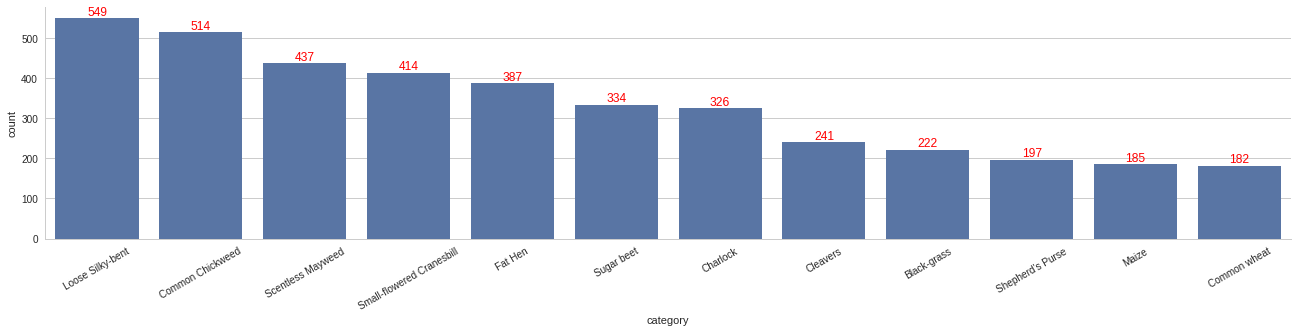

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

g = sns.factorplot("category", data=train_data, aspect=4.5, kind="count", color="b", order = train_data['category'].value_counts().index)
g.set_xticklabels(rotation=30)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


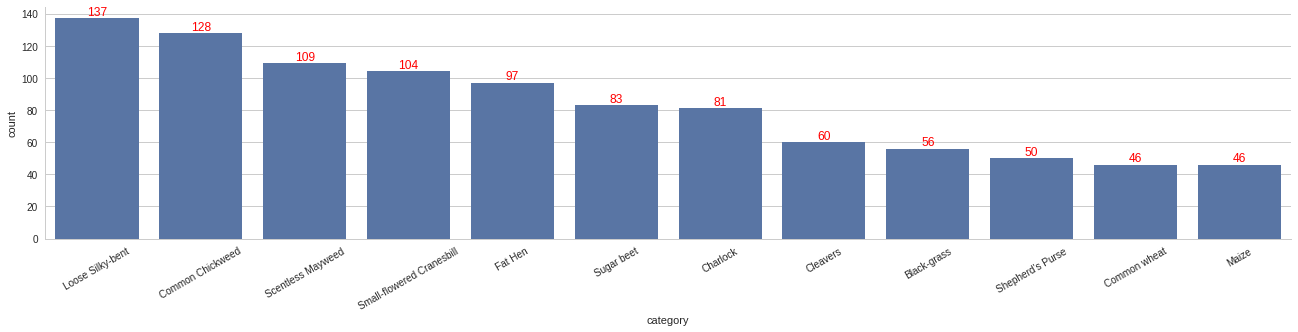

In [10]:
sns.set(color_codes=True)
pal = sns.color_palette()
sns.set_style("whitegrid")

g = sns.factorplot("category", data=valid_data, aspect=4.5, kind="count", color="b",  order = valid_data['category'].value_counts().index)
g.set_xticklabels(rotation=30)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height(), '%d' % int(p.get_height()), 
            fontsize=12, color='red', ha='center', va='bottom')


In [0]:
rs = []
gs = []
bs = []
to_tensor = transforms.ToTensor()
for index, example in train_data.iterrows():

    image = Image.open(example['file']).convert('RGB')
    image_pixels = to_tensor(image).numpy()
    rs.append(image_pixels[:, :, 0].flatten())
    gs.append(image_pixels[:, :, 1].flatten())
    bs.append(image_pixels[:, :, 2].flatten())

    

rs = np.concatenate(rs)
gs = np.concatenate(gs)
bs = np.concatenate(bs)

mean_rgb = [np.mean(rs).item(), np.mean(gs).item(), np.mean(bs).item()]
std_rgb = [np.std(rs).item(), np.std(gs).item(), np.std(bs).item()]


In [12]:
(mean_rgb, std_rgb)

([0.30771857500076294, 0.3074255585670471, 0.3070955276489258],
 [0.15300801396369934, 0.1525620073080063, 0.15213675796985626])

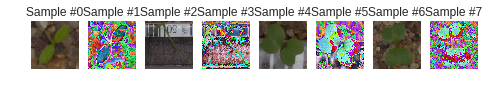

In [13]:
import matplotlib.pyplot as plt
imagesToShow = 4
# mean_rgb = [0.485, 0.456, 0.406]
# std_rgb =[0.229, 0.224, 0.225]


normalize_img = transforms.Normalize(mean=mean_rgb, std=std_rgb)


image_size = 224

normalized_train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img
    ])


normalized_train_set = DatasetLoader(train_data, normalized_train_data_transform)

normalized_train_loader = DataLoader(normalized_train_set, batch_size=1, shuffle=True, num_workers=0)



def flaotTensorToImage(img, mean=0, std=1):
  """convert a tensor to an image"""
  img = np.transpose(img.numpy(), (1, 2, 0))
  img = (img*std+ mean)*255
  img = img.astype(np.uint8)    
  return img   


imageINdex = 0
for i, data in enumerate(normalized_train_loader, 0):
  images, labels = data            
  image=images[0]
  
  ax = plt.subplot(1, imagesToShow * 2, imageINdex + 1)
  ax.set_title('Sample #{}'.format(imageINdex))
  ax.axis('off')
  plt.imshow (flaotTensorToImage(image,mean_rgb,std_rgb))
  
  
  imageINdex += 1
  ax = plt.subplot(1, imagesToShow * 2, imageINdex + 1)
  ax.set_title('Sample #{}'.format(imageINdex))
  ax.axis('off')
  plt.imshow (flaotTensorToImage(image))
  imageINdex +=1
  

  if i==imagesToShow-1:
    break  
        

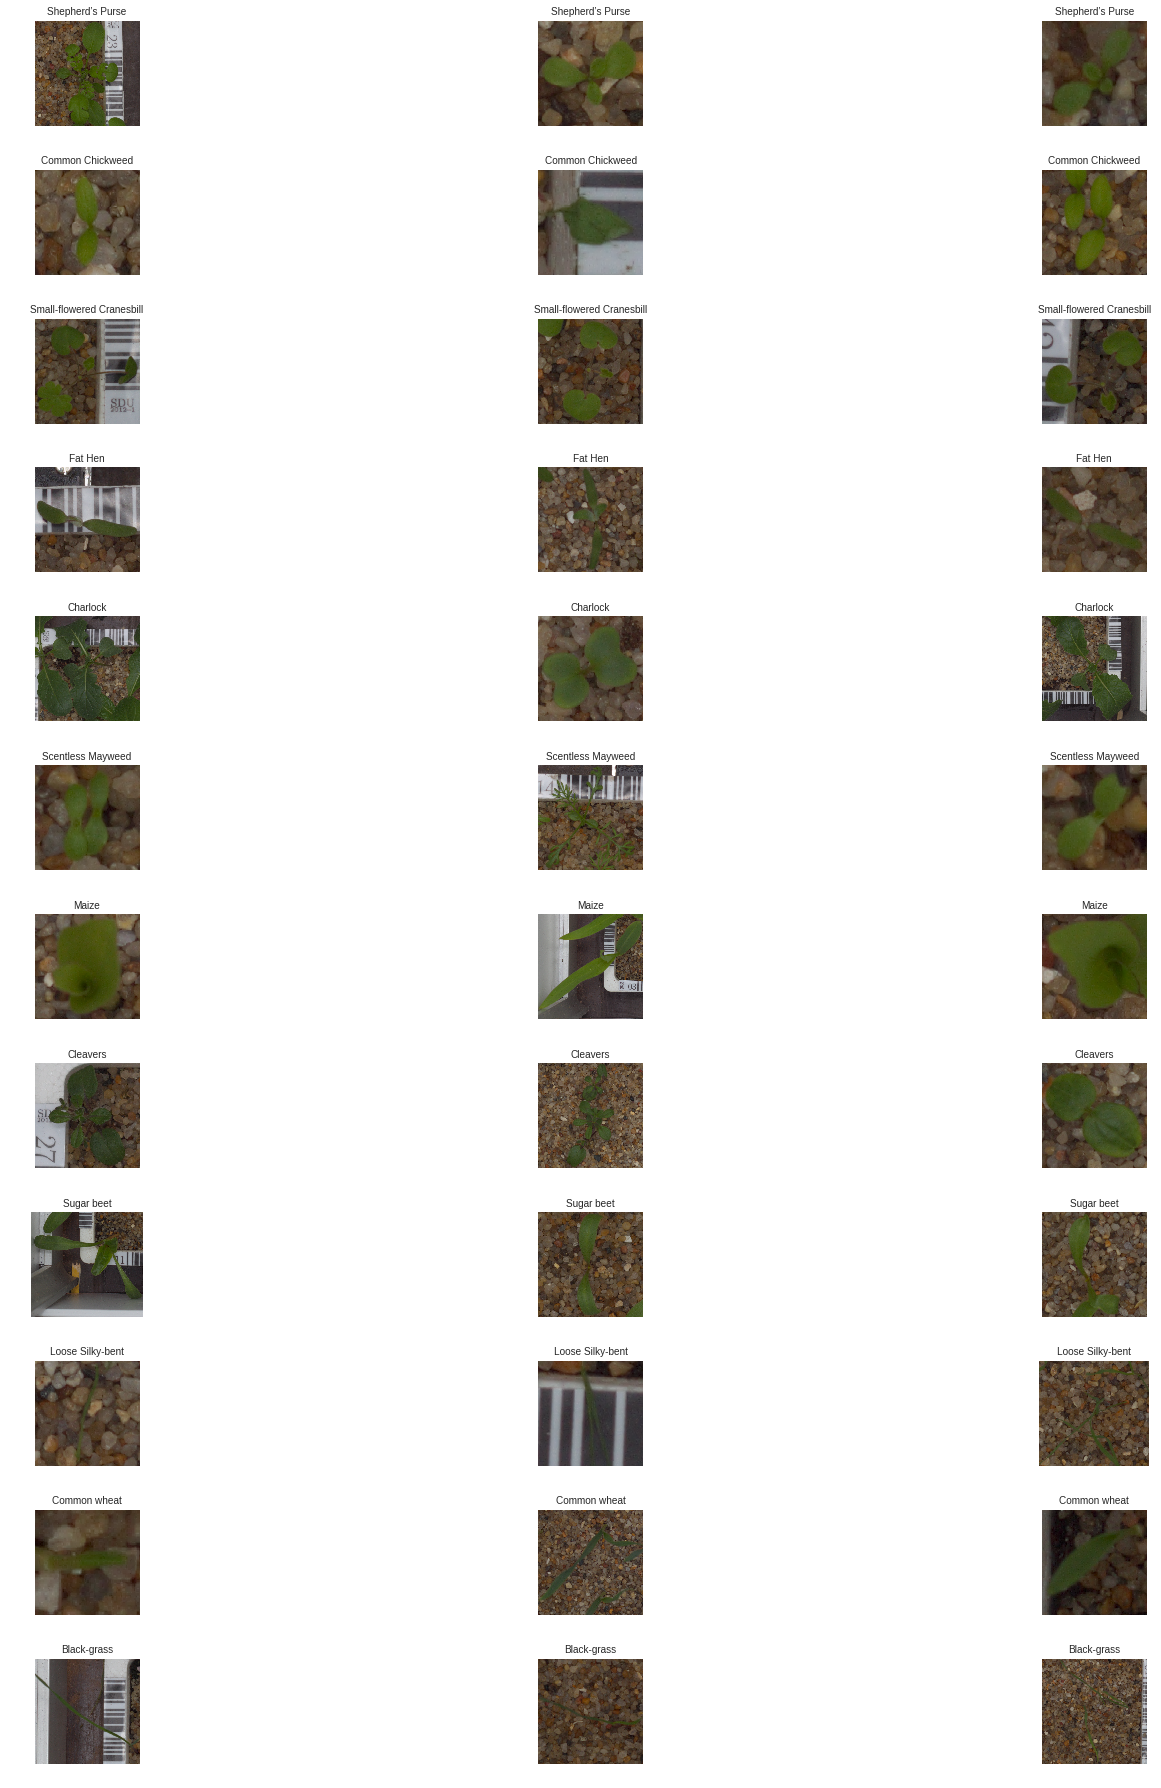

In [14]:
plt.figure(figsize=(25,25));
k = 0
for  category_id, category in index_class.items():

    samles = train_data[train_data.category_id == category_id].sample(3)

    for _, sample in samles.iterrows():
        plt.subplot(len(index_class), 3, k + 1)
        image = Image.open(sample['file']).convert('RGB')
        plt.imshow(image,shape=(12,10))
        plt.axis('off');
        plt.title(category, fontsize=10)
        k+=1

plt.tight_layout()

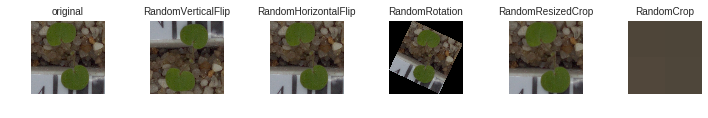

In [48]:
plt.figure(figsize=(10,10))
file_path = train_data.iloc[0]['file']
image = Image.open(file_path).convert('RGB')                
# transformed_sample
# # fig = plt.figure()
# plt.subplot(1, 3,  1)
# # # sample = face_dataset[65]
# plt.subplot(1, 3,  1)
# plt.imshow(transformed_sample)
# plt.axis('off');

# plt.subplot(1, 3,  2)
# vertical = transforms.RandomVerticalFlip(p=1)(transformed_sample)
# plt.imshow(vertical)
# plt.axis('off');
# plt.tight_layout()



transformations =[('original',  lambda x:x), transforms.RandomVerticalFlip(p=1), transforms.RandomHorizontalFlip(),
                  transforms.RandomRotation(degrees=40, expand=True), transforms.RandomResizedCrop(image_size, scale=(0.6, 1.0)),
                  transforms.RandomCrop(2)]

for index,  tsfrm in enumerate(transformations):
  
  
  if isinstance(tsfrm, tuple):
    name = tsfrm[0]
    tsfrm = tsfrm[1]
  else:
    name = type(tsfrm).__name__
    
  
  transformed_sample = tsfrm(image)
  plt.subplot(1, len(transformations),  index + 1)
  plt.imshow(transformed_sample)
  plt.axis('off');
  plt.title(name, fontsize=10)
  

plt.tight_layout()  
  


# transforms.CenterCrop(224)(transformed_sample)
# transforms.RandomResizedCrop(image_size)(transformed_sample)

# # for i, tsfrm in enumerate([scale, crop, composed]):
  
# image = Image.open(train_data.iloc[0][file]).convert('RGB')
# transformed_sample = tsfrm(sample)

# ax = plt.subplot(1, 3, i + 1)
# plt.tight_layout()
# #ax.set_title(type(tsfrm).__name__)
# show_landmarks(**transformed_sample)

# plt.show()

In [0]:
from torch.utils.data import Dataset, DataLoader

hidden_size = 500  
num_classes = 12  
num_epochs = 100  
momentum = 0.9
batch_size = 8 
learning_rate = 0.001

input_size = image_size * image_size * 3 


# pop_std0,pop_mean


normalize_img_trabnsform = transforms.Normalize(mean=mean_rgb,
                                     std=std_rgb)



train_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor()
    ])

train_data_transform_with_normalization = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])
	
  
valid_data_transform_with_normalization = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])
	
  
valid_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor()
    ])

test_data_transform = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor()
    ])
	
test_data_transform_with_normalization = transforms.Compose([
        transforms.Resize(size=(image_size,image_size)),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])

train_set = DatasetLoader(train_data, train_data_transform)
train_set_with_notmalization = DatasetLoader(train_data, train_data_transform_with_normalization)


valid_set_with_normalization = DatasetLoader(valid_data, valid_data_transform_with_normalization)
valid_set = DatasetLoader(valid_data, valid_data_transform)

test_set = DatasetLoader(test_data, test_data_transform)
test_set_with_normalization = DatasetLoader(test_data, test_data_transform_with_normalization)

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4)
train_loader_with_normalization = DataLoader(train_set_with_notmalization, batch_size=batch_size, shuffle=True, num_workers=4)

validation_loader_with_normalization = DataLoader(valid_set_with_normalization, batch_size=batch_size, shuffle=True, num_workers=4)
validation_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=4)



test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader_with_normalization = DataLoader(test_set_with_normalization, batch_size=batch_size, shuffle=True, num_workers=4)





In [0]:
class NetA(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NetA, self).__init__()  # Inherited from the parent class nn.Module
        self.fc1 = nn.Linear(input_size, hidden_size)  # 1st Full-Connected Layer: 784 (input data) -> 500 (hidden node)
        self.relu = nn.ReLU()  # Non-Linear ReLU Layer: max(0,x)
        self.fc2 = nn.Linear(hidden_size,
                             num_classes)  # 2nd Full-Connected Layer: 500 (hidden node) -> 10 (output class)

    def forward(self, x):  # Forward pass: stacking each layer together
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

class LeNet(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(num_rgb, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(44944, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        n1 = self.num_flat_features(out)
        out = out.view(-1, n1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        
        out = self.fc3(out)
        return out
    
        
    def num_flat_features(self, x):
      size = x.size()[1:]
      num_features = 1
      for s in size:
        num_features *= s
      return num_features
            
        
      


In [0]:

def train(model, data_loader, confusion_matrix, optimizer, criterion, input_transformation = None):
  calc_loss = 0.
  calc_correct = 0.
  calc_count = 0.
  
  model.train()
  
  for images, labels in  data_loader:
    
    if input_transformation:
      images = input_transformation(images)
    
    images = images.cuda()
    labels = labels.cuda()
    images = Variable(images)  
    labels = Variable(labels)
        
    output = model(images)
    
    _, pred = torch.max(output.data, 1)
    
    loss = criterion(output, labels)
    calc_loss +=loss.item()
    calc_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
    calc_count+=output.data.shape[0]    
    optimizer.zero_grad()
    loss.backward() 
    optimizer.step()
    confusion_matrix.add(pred, labels)
    
  return round(calc_loss/calc_count, 4), round(calc_correct/calc_count, 4)

def score(model, data_loader, confusion_matrix, criterion, input_transformation = None):
  
  running_loss = 0.
  running_correct =0.
  calc_count =0.
  
  model.eval()
  
  with torch.no_grad():
    for images, labels in data_loader:
      if input_transformation:
        images = input_transformation(images)
      
      images = images.cuda()
      labels = labels.cuda()
      images = Variable(images)  
      labels = Variable(labels)
      
      outputs = model(images)
      _, pred = torch.max(outputs.data, 1)
      loss = criterion(outputs, labels)
      
      running_correct +=torch.sum(pred==labels.data).cpu().numpy().item()
      calc_count+=outputs.data.shape[0]
      running_loss += loss.item()
      confusion_matrix.add(pred, labels)
  
  return round(running_loss/calc_count, 4), round(running_correct/calc_count, 4)
      
      




In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
 

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
#NetA without normalization
from torchnet.meter import ConfusionMeter
trainning_confusion_matrix = ConfusionMeter(num_classes)
validation_confusion_matrix = ConfusionMeter(num_classes)
test_confusion_matrix = ConfusionMeter(num_classes)

liveloss = PlotLosses()
model = NetA(input_size, hidden_size, num_classes).cuda()
tranform = lambda input: input.view(-1, image_size * image_size * 3)
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)
for epoch in range(num_epochs):
  loss, correct = train(model, train_loader, trainning_confusion_matrix, optimizer, criterion, tranform)
  
  val_loss, val_correct = score(model, validation_loader, validation_confusion_matrix, criterion, tranform)
  liveloss.update({
        'log loss': loss,
        'val_log loss': val_loss,
        'accuracy': correct,
        'val_accuracy': val_correct
    })
    
  
  liveloss.draw()

test_loss, test_correct = score(model, test_loader, test_confusion_matrix, criterion, tranform)  

print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))


NameError: ignored

In [0]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

def plt_confusion_matrix(cm, class_names, normalize =False):
  
  if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      
  
  df_cm = pd.DataFrame(cm, index = [i for i in class_names],
                    columns = class_names)
  
  plt.figure(figsize = (10,7))
  sn.heatmap(df_cm, annot=True)

# plt_confusion_matrix(trainning_confusion_matrix.value(), class_names, False)  

In [0]:
# LeNet without normalization

from torchnet.meter import ConfusionMeter
trainning_confusion_matrix = ConfusionMeter(num_classes)
validation_confusion_matrix = ConfusionMeter(num_classes)

liveloss = PlotLosses()
model = LeNet().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)


for epoch in range(num_epochs):
  loss, correct = train(model, train_loader, trainning_confusion_matrix, optimizer, criterion)
  
  val_loss, val_correct = score(model, validation_loader, validation_confusion_matrix, criterion)
  liveloss.update({
        'log loss': loss,
        'val_log loss': val_loss,
        'accuracy': correct,
        'val_accuracy': val_correct
    })
    
  
  liveloss.draw()

test_loss, test_correct = score(model, test_loader, test_confusion_matrix, criterion)  

print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))  

NameError: ignored

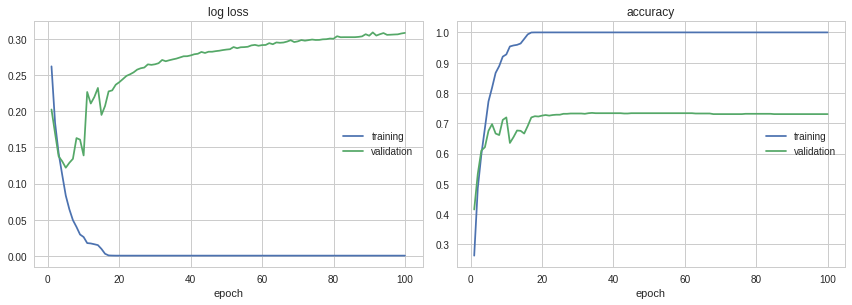

log loss:
training   (min:    0.000, max:    0.262, cur:    0.000)
validation (min:    0.122, max:    0.309, cur:    0.309)

accuracy:
training   (min:    0.263, max:    1.000, cur:    1.000)
validation (min:    0.415, max:    0.734, cur:    0.730)
test_loss =0.328 test_correct=0.713


In [0]:


#lanet + normalization
from torchnet.meter import ConfusionMeter
trainning_confusion_matrix = ConfusionMeter(num_classes)
validation_confusion_matrix = ConfusionMeter(num_classes)

liveloss = PlotLosses()
model = LeNet().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)


for epoch in range(num_epochs):
  loss, correct = train(model, train_loader_with_normalization, trainning_confusion_matrix, optimizer, criterion)
  
  val_loss, val_correct = score(model, validation_loader_with_normalization, validation_confusion_matrix, criterion)
  liveloss.update({
        'log loss': loss,
        'val_log loss': val_loss,
        'accuracy': correct,
        'val_accuracy': val_correct
    })
    
  
  liveloss.draw()
  
test_loss, test_correct = score(model, test_loader_with_normalization, test_confusion_matrix, criterion)  

print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))

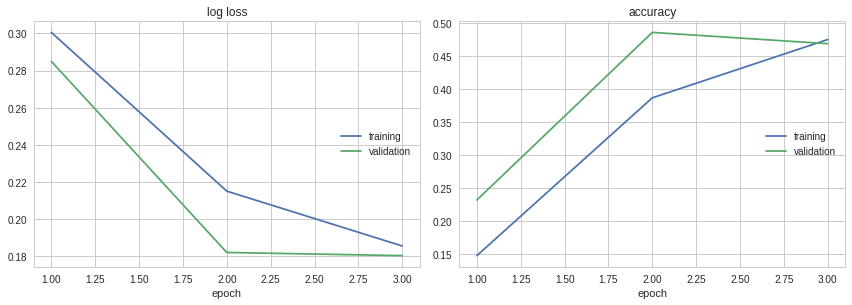

log loss:
training   (min:    0.186, max:    0.300, cur:    0.186)
validation (min:    0.180, max:    0.285, cur:    0.180)

accuracy:
training   (min:    0.147, max:    0.475, cur:    0.475)
validation (min:    0.232, max:    0.485, cur:    0.468)
1


In [0]:
#lanet + normalization + augmentation

from torchnet.meter import ConfusionMeter
trainning_confusion_matrix = ConfusionMeter(num_classes)
validation_confusion_matrix = ConfusionMeter(num_classes)

liveloss = PlotLosses()
model = LeNet().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=momentum)


train_data_transform_with_normalization_and_augmentation = transforms.Compose([
     #transforms.Resize(size=(image_size,image_size)),
    #transforms.RandomResizedCrop(size=(image_size,image_size)
		 transforms.Resize(size=(image_size,image_size)),
		transforms.RandomHorizontalFlip(),
		transforms.RandomVerticalFlip(),
		transforms.RandomRotation(degrees=20),
        transforms.ToTensor(),
        normalize_img_trabnsform
    ])


train_set_with_notmalization_and_augmentation = DatasetLoader(train_data, train_data_transform_with_normalization_and_augmentation)


train_loader_with_normalization_and_augmentation  = DataLoader(train_set_with_notmalization_and_augmentation, batch_size=batch_size, shuffle=True, num_workers=4)


for epoch in range(num_epochs):
  loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
  val_loss, val_correct = score(model, validation_loader_with_normalization, validation_confusion_matrix, criterion)
  liveloss.update({
        'log loss': loss,
        'val_log loss': val_loss,
        'accuracy': correct,
        'val_accuracy': val_correct
    })
    
  
  liveloss.draw()
  
test_loss, test_correct = score(model, test_loader_with_normalization, test_confusion_matrix, criterion)  

print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))

In [0]:
#lanet + normalization + augmentation
from torchnet.meter import ConfusionMeter

def trainLanet(trainning_lr, trainning_batch_size):

  
  trainning_confusion_matrix = ConfusionMeter(num_classes)
  validation_confusion_matrix = ConfusionMeter(num_classes)
  test_confusion_matrix = ConfusionMeter(num_classes)



  liveloss = PlotLosses()
  model = LeNet().cuda()
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=trainning_lr, momentum=momentum)


  train_data_transform_with_normalization_and_augmentation = transforms.Compose([
       #transforms.Resize(size=(image_size,image_size)),
       transforms.Resize(size=(image_size,image_size)),
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=20),
          transforms.ToTensor(),
          normalize_img_trabnsform
      ])


  train_set_with_notmalization_and_augmentation = DatasetLoader(train_data, train_data_transform_with_normalization_and_augmentation)


  train_loader_with_normalization_and_augmentation  = DataLoader(train_set_with_notmalization_and_augmentation, batch_size=trainning_batch_size, shuffle=True, num_workers=4)


  for epoch in range(num_epochs):
    loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
    val_loss, val_correct = score(model, validation_loader_with_normalization, validation_confusion_matrix, criterion)
    liveloss.update({
          'log loss': loss,
          'val_log loss': val_loss,
          'accuracy': correct,
          'val_accuracy': val_correct
      })


    liveloss.draw()

  test_loss, test_correct = score(model, test_loader_with_normalization, test_confusion_matrix, criterion)  

  print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))


In [0]:
trainLanet(0.001, 16)

In [0]:
class LaNet2(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(LaNet2, self).__init__()
        self.conv1 = nn.Conv2d(num_rgb, 6, 5)
        self.dropout1 = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.dropout2 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(44944, 120)
        self.dropout3 = nn.Dropout(p=0.4)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        

        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.dropout1(out)
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = self.dropout2(out)
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        n1 = self.num_flat_features(out)
        out = out.view(-1, n1)
        out = self.dropout3(out)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = F.log_softmax(self.fc3(out))
        
        return out


    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
from torchnet.meter import ConfusionMeter

def trainLanet2(trainning_lr, trainning_batch_size):

  
  trainning_confusion_matrix = ConfusionMeter(num_classes)
  validation_confusion_matrix = ConfusionMeter(num_classes)
  test_confusion_matrix = ConfusionMeter(num_classes)



  liveloss = PlotLosses()
  model = LaNet2().cuda()
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=trainning_lr, momentum=momentum)
  #optimizer = torch.optim.Adam(model.parameters(), lr=trainning_lr, weight_decay=0.)


  train_data_transform_with_normalization_and_augmentation = transforms.Compose([
      
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      
#       transforms.RandomRotation(degrees=20),
#       transforms.RandomResizedCrop(image_size),
      # transforms.Resize(size=(image_size,image_size)),
          transforms.ToTensor(),
          normalize_img_trabnsform
      ])


  train_set_with_notmalization_and_augmentation = DatasetLoader(train_data, train_data_transform_with_normalization_and_augmentation)


  train_loader_with_normalization_and_augmentation  = DataLoader(train_set_with_notmalization_and_augmentation, batch_size=trainning_batch_size, shuffle=True, num_workers=4)


  for epoch in range(num_epochs):
    loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
    val_loss, val_correct = score(model, validation_loader_with_normalization, validation_confusion_matrix, criterion)
    liveloss.update({
          'log loss': loss,
          'val_log loss': val_loss,
          'accuracy': correct,
          'val_accuracy': val_correct
      })


    liveloss.draw()

  test_loss, test_correct = score(model, test_loader_with_normalization, test_confusion_matrix, criterion)  

  print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))        

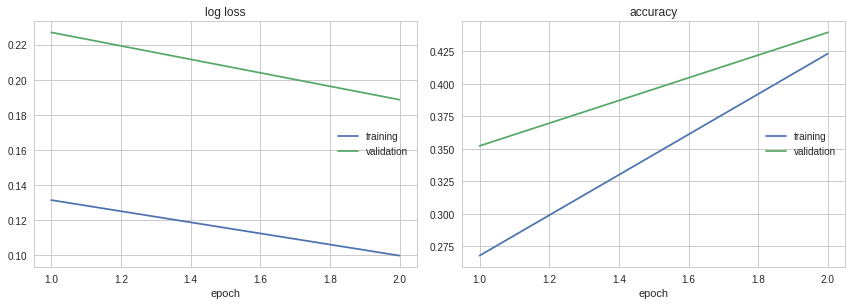

log loss:
training   (min:    0.100, max:    0.132, cur:    0.100)
validation (min:    0.189, max:    0.227, cur:    0.189)

accuracy:
training   (min:    0.268, max:    0.423, cur:    0.423)
validation (min:    0.352, max:    0.439, cur:    0.439)


Process Process-3170:
Process Process-3171:
Process Process-3172:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-3169:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_indices])
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **sel

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-eed30425bfcf>", line 1, in <module>
    trainLanet2(0.004, trainning_batch_size=16)
  File "<ipython-input-33-6967eb9d1178>", line 78, in trainLanet2
    loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
  File "<ipython-input-23-a1e3ab9dc683>", line 9, in train
    for images, labels in  data_loader:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.
--- Logging error ---
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-34-eed30425bfcf>", line 1, in <module>
    trainLanet2(0.004, trainning_batch_size=16)
  File "<ipython-input-33-6967eb9d1178>", line 78, in trainLanet2
    loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
  File "<ipython-input-23-a1e3ab9dc683>", line 9, in train
    for images, labels in  data_loader:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 280, in __next__
    idx, batch = self._get_batch()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 259, in _get_batch
    return self.data_queue.get

KeyboardInterrupt: ignored

In [0]:
trainLanet2(0.004, trainning_batch_size=16)

In [0]:

class Gabi1(nn.Module):
    def __init__(self, num_classes=12, num_rgb=3):
        super(Gabi1, self).__init__()

        self.conv1 = nn.Conv2d(num_rgb, 6, 7)

        self.dropout1 = nn.Dropout(p=0.2)

        self.conv2 = nn.Conv2d(6, 16, 5)

        self.dropout2 = nn.Dropout(p=0.2)

        #         self.fc1 = nn.Linear(43264, 600)

        self.dropout3 = nn.Dropout(p=0.2)

        #         self.fc2 = nn.Linear(600, 120)
        self.fc2 = nn.Linear(10000, 120)

        #         self.dropout4 = nn.Dropout(p=0.2)

        self.fc3 = nn.Linear(120, 85)

        self.dropout5 = nn.Dropout(p=0.4)

        self.fc4 = nn.Linear(85, num_classes)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        out = F.relu(self.conv1(x))

        out = self.dropout1(out)

        out = F.max_pool2d(out, 4)

        out = F.relu(self.conv2(out))
        out = self.dropout2(out)

        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        n1 = self.num_flat_features(out)
        out = out.view(-1, n1)

        #         out = F.relu(self.fc1(out))

        #         out = self.dropout4(out)

        out = F.relu(self.fc2(out))

        out = self.dropout5(out)

        out = F.relu(self.fc3(out))
        
              
        out = F.log_softmax(self.fc4(out), dim=1)

        return out

    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

      
from torchnet.meter import ConfusionMeter

def trainGabi1(trainning_lr, trainning_batch_size):

  print('trainGabi1')
  trainning_confusion_matrix = ConfusionMeter(num_classes)
  validation_confusion_matrix = ConfusionMeter(num_classes)
  test_confusion_matrix = ConfusionMeter(num_classes)



  liveloss = PlotLosses()
  model = Gabi1().cuda()
  criterion = nn.CrossEntropyLoss().cuda()
  #optimizer = torch.optim.SGD(model.parameters(), lr=trainning_lr, momentum=momentum)
  optimizer = torch.optim.Adam(model.parameters(), lr=trainning_lr, weight_decay=0.)


  train_data_transform_with_normalization_and_augmentation = transforms.Compose([
      
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=20),
       transforms.RandomResizedCrop(image_size),
      #transforms.Resize(size=(image_size,image_size)),
          transforms.ToTensor(),
          normalize_img_trabnsform
      ])


  train_set_with_notmalization_and_augmentation = DatasetLoader(train_data, train_data_transform_with_normalization_and_augmentation)


  train_loader_with_normalization_and_augmentation  = DataLoader(train_set_with_notmalization_and_augmentation, batch_size=trainning_batch_size, shuffle=True, num_workers=4)


  for epoch in range(num_epochs):
    loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
    val_loss, val_correct = score(model, validation_loader_with_normalization, validation_confusion_matrix, criterion)
    liveloss.update({
          'log loss': loss,
          'val_log loss': val_loss,
          'accuracy': correct,
          'val_accuracy': val_correct
      })


    liveloss.draw()

  test_loss, test_correct = score(model, test_loader_with_normalization, test_confusion_matrix, criterion)  

  print('gab1 test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))        

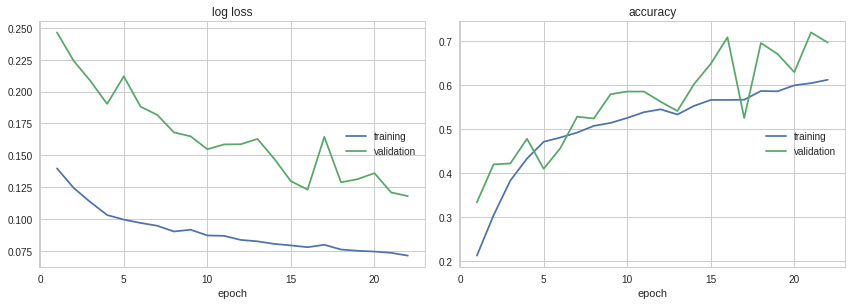

log loss:
training   (min:    0.071, max:    0.140, cur:    0.071)
validation (min:    0.118, max:    0.246, cur:    0.118)

accuracy:
training   (min:    0.212, max:    0.612, cur:    0.612)
validation (min:    0.333, max:    0.719, cur:    0.696)


Process Process-420:
Process Process-419:
Traceback (most recent call last):
Process Process-418:
Traceback (most recent call last):
Process Process-417:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples = collate_fn([dataset[i] for i in batch_ind

KeyboardInterrupt: ignored

KeyboardInterrupt


In [0]:
trainGabi1(0.001, 16)

In [0]:
import torchvision.models as models
# alexnet = models.alexnet(pretrained=True)


from torchnet.meter import ConfusionMeter

def trainAlexNet(trainning_lr, trainning_batch_size):

  
  trainning_confusion_matrix = ConfusionMeter(num_classes)
  validation_confusion_matrix = ConfusionMeter(num_classes)
  test_confusion_matrix = ConfusionMeter(num_classes)



  liveloss = PlotLosses()
  model = models.alexnet(pretrained=True).cuda()
  
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = torch.optim.SGD(model.parameters(), lr=trainning_lr, momentum=momentum)
  #optimizer = torch.optim.Adam(model.parameters(), lr=trainning_lr, weight_decay=0.)


  train_data_transform_with_normalization_and_augmentation = transforms.Compose([
      
      transforms.RandomHorizontalFlip(),
      transforms.RandomVerticalFlip(),
      transforms.RandomRotation(degrees=20),
      transforms.RandomResizedCrop(image_size),
      # transforms.Resize(size=(image_size,image_size)),
          transforms.ToTensor(),
          normalize_img_trabnsform
      ])


  train_set_with_notmalization_and_augmentation = DatasetLoader(train_data, train_data_transform_with_normalization_and_augmentation)


  train_loader_with_normalization_and_augmentation  = DataLoader(train_set_with_notmalization_and_augmentation, batch_size=trainning_batch_size, shuffle=True, num_workers=4)


  for epoch in range(num_epochs):
    loss, correct = train(model, train_loader_with_normalization_and_augmentation, trainning_confusion_matrix, optimizer, criterion)
    val_loss, val_correct = score(model, validation_loader_with_normalization, validation_confusion_matrix, criterion)
    liveloss.update({
          'log loss': loss,
          'val_log loss': val_loss,
          'accuracy': correct,
          'val_accuracy': val_correct
      })


    liveloss.draw()

  test_loss, test_correct = score(model, test_loader_with_normalization, test_confusion_matrix, criterion)  

  print('test_loss ={test_loss} test_correct={test_correct}'.format(test_loss=test_loss, test_correct=test_correct))        

NameError: ignored